In [12]:
import numpy as np
from numpy import pi
import pandas as pd
import scipy.optimize as optimize
from scipy import interpolate
from scipy.optimize import fsolve, curve_fit
import scipy.fftpack as sfft

import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import MultipleLocator, FixedFormatter
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter
import matplotlib.animation as animation
from IPython.display import display, HTML, Video
import IPython

from numpy.polynomial.hermite import hermval
from math import factorial
from skimage import measure
import cv2
import finesse
from finesse.gaussian import HGMode

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

finesse.configure(plotting=True)

(0.17249076834494562+0j)
49765545.873874106
(3.0413216129604293e-21+0j)
(0.17249076834494562+0j)
49765545.873874106
(3.0413216129604293e-21+0j)


(-0.5, 399.5, -0.5, 399.5)

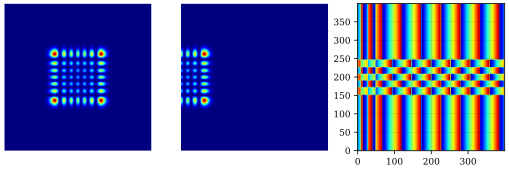

In [2]:
q_0 = 1j 
x = y = np.linspace(-0.004, 0.004, 400)

HG66 = HGMode(q_0, n=6, m=6)
HG66_data = HG66.unm(x, y);
HG66_data_offset = HG66.unm(x=x, y=y-y[0])*np.exp(1j*2*np.pi/(1064e-9)*np.sin(0.001)*x)

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(9, 5))
ax1.imshow(np.abs(HG66_data)**2, cmap="jet")
ax2.imshow(np.abs(HG66_data_offset)**2, cmap="jet")
ax3.imshow(np.angle(HG66_data_offset), cmap="jet")
ax1.axis("off")
ax2.axis("off")
# fig.savefig('HG00.pdf', bbox_inches='tight', dpi=120, pad_inches=0.01);

(5.3444309853959675+0j)
-860.0898201517888
(7.426181972671784e-06+0j)


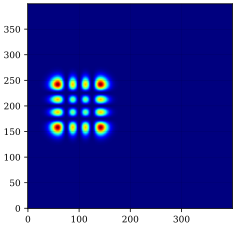

In [3]:
def UnmLateralOffset(q, n, m, x0):
    HGmn = HGMode(q, m=m, n=n)

    U_n = HGmn.un(x+x0)
    U_m = HGmn.um(y)
    U_mn = np.outer(U_m, U_n)

    return U_mn

HG33 = UnmLateralOffset(1j, 3, 3, -x[0]/2)
plt.imshow(np.abs(HG33)**2, cmap="jet");

(37.02730401700486+0j)
1.0
(3.0413216129604293e-21+0j)
(13.091128879740014+0j)
375.93595832659173
(3.0413216129604293e-21+0j)
(37.02730401700486+0j)
1.0
(3.0413216129604293e-21+0j)


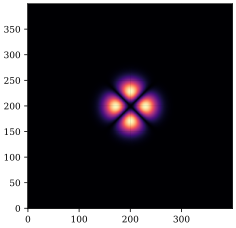

In [4]:
q_0 = 1j 
x = y = np.linspace(-0.004, 0.004, 400)

HG00 = HGMode(q_0, n=0, m=0)
HG02 = HGMode(q_0, n=0, m=2)
HG20 = HGMode(q_0, n=2, m=0)
HG00_data = HG00.unm(x, y)
HG20_data = HG20.unm(x, y)
HG02_data = HG02.unm(x, y)
modemismatch = HG20_data + HG02_data
modemismatch_convert = HG20_data - HG02_data
plt.imshow(np.abs(modemismatch))
plt.imshow(np.abs(modemismatch_convert))

In [1]:
x = y = np.linspace(-0.004, 0.004, 400)
step = x[1]-x[0]
def eta_n(n, delta_x=0, alpha=0):
    HGnn_0 = HGMode(q_0, n=n, m=n)

    HGnn_0_data = HGnn_0.unm(x, y)
    
    HGnn_prime_data =  HGnn_0.unm(x-delta_x, y)*np.exp(1j*2*np.pi/(1064e-9)*(alpha)*x)
    # HGnn_prime_data = UnmLateralOffset(q_0, n, n, delta_x)*np.exp(1j*2*np.pi/(1064e-9)*(alpha)*x)
        
    rho_nn = np.sum(np.conj(HGnn_0_data)*HGnn_prime_data * step * step)
    eta = np.abs(rho_nn*np.conj(rho_nn))
    
    return eta
    
q_0 = 1j 
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5
Theta = 1064e-9/np.pi/w0
alphas = np.linspace(-2, 2, 50)*0.27*Theta
powerMisalignment_a_0 = []
powerMisalignment_a_3 = []
for idx, alpha in enumerate(alphas):
    etas = []
    for n in range(7):
        etas.append(eta_n(n, alpha=alpha))

    powerMisalignment_a_0.append(1-etas[0])
    powerMisalignment_a_3.append(1-etas[3])

powerMisalignment_a_0 = np.array(powerMisalignment_a_0)
powerMisalignment_a_3 = np.array(powerMisalignment_a_3)

xs = np.linspace(-2, 2, 50)*0.2685*w0
powerMisalignment_x_0 = []
powerMisalignment_x_3 = []
for idx, x0 in enumerate(xs):
    etas = []
    for n in range(7):
        etas.append(eta_n(n, delta_x=x0))

    powerMisalignment_x_0.append(1-etas[0])
    powerMisalignment_x_3.append(1-etas[3])

powerMisalignment_x_0 = np.array(powerMisalignment_x_0)
powerMisalignment_x_3 = np.array(powerMisalignment_x_3)

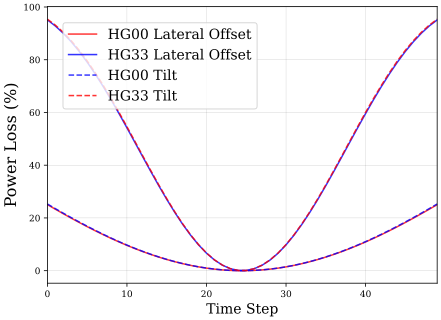

In [6]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(powerMisalignment_x_0*100, color="r", label="HG00 Lateral Offset", alpha=0.8, lw=1.5)
ax.plot(powerMisalignment_x_3*100, color="b", label="HG33 Lateral Offset", alpha=0.8, lw=1.5)

ax.plot(powerMisalignment_a_0*100, color="b", ls="--", label="HG00 Tilt", alpha=0.8, lw=1.5)
ax.plot(powerMisalignment_a_3*100, color="r", ls="--", label="HG33 Tilt", alpha=0.8, lw=1.5)

# ax.plot(np.sum(powerMisalignment_x_3_HOM*100, axis=1));
# ax.plot(np.sum(powerMisalignment_a_3_HOM*100, axis=1), color="k", ls="-." );

legend = plt.legend(fontsize=14, ncols=1, loc=(0.04, 0.63));

ax.set_xlabel("Time Step", fontsize=14)
ax.set_ylabel("Power Loss (%)", fontsize=16);

In [7]:
def eta_nm_func(q, n, m, HGnn_prime_data):
    HGnm = HGMode(q=q, n=n, m=m)
    HGnm_data = HGnm.unm(x, y)

    rho_nm = np.sum(np.conj(HGnm_data)*HGnn_prime_data * step * step)
    eta_nm = np.abs(rho_nm*np.conj(rho_nm))
    
    return eta_nm

In [2]:
x = y = np.linspace(-0.004, 0.004, 400)
step = x[1]-x[0]
def eta_n_HOM(n, q, delta_x=0, alpha=0):
    HGnn_0 = HGMode(q, m=n, n=n)

    HGnn_prime_data = HGnn_0.unm(x-delta_x, y)*np.exp(1j*2*np.pi/(1064e-9)*(alpha)*x)

    eta_nms = []
    for deltan in [1, 2, 3, 4, -1, -2, -3]:
        n_new = n + deltan
        m_new = n
        eta_nm = eta_nm_func(q=q, n=n_new, m=m_new, HGnn_prime_data=HGnn_prime_data)
        eta_nms.append(eta_nm)
            
    return eta_nms
    
q_0 = 1j 
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5
Theta = 1064e-9/np.pi/w0
alphas = np.linspace(-2, 2, 50)*0.27*Theta
powerMisalignment_a_3_HOM = []
for idx, alpha in enumerate(alphas):
    eta_p, eta_pp, eta_ppp, eta_pppp, eta_m, eta_mm, eta_mmm = eta_n_HOM(n=3, q=q_0, alpha=alpha)
    powerMisalignment_a_3_HOM.append([eta_p, eta_pp, eta_ppp, eta_pppp, eta_m, eta_mm, eta_mmm])

powerMisalignment_a_3_HOM = np.array(powerMisalignment_a_3_HOM)

xs = np.linspace(-2, 2, 50)*0.2685*w0
powerMisalignment_x_3_HOM = []
for idx, x0 in enumerate(xs):
    eta_p, eta_pp, eta_ppp, eta_pppp, eta_m, eta_mm, eta_mmm = eta_n_HOM(n=3, q=q_0, delta_x=x0)
    powerMisalignment_x_3_HOM.append([eta_p, eta_pp, eta_ppp, eta_pppp, eta_m, eta_mm, eta_mmm])

powerMisalignment_x_3_HOM = np.array(powerMisalignment_x_3_HOM)

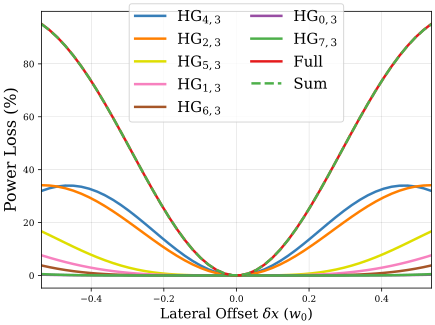

In [21]:
CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']

fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,0], label=r"$\mathrm{HG}_{4,3}$", color=CB_color_cycle[0], lw=2.5)
ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,4], label=r"$\mathrm{HG}_{2,3}$", color=CB_color_cycle[1], lw=2.5)

ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,1], label=r"$\mathrm{HG}_{5,3}$", color=CB_color_cycle[8], lw=2.5)
ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,5], label=r"$\mathrm{HG}_{1,3}$", color=CB_color_cycle[3], lw=2.5)

ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,2], label=r"$\mathrm{HG}_{6,3}$", color=CB_color_cycle[4], lw=2.5)
ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,6], label=r"$\mathrm{HG}_{0,3}$", color=CB_color_cycle[5], lw=2.5)
ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,3], label=r"$\mathrm{HG}_{7,3}$", color=CB_color_cycle[2], lw=2.5)
ax.plot(xs/w0, 100*powerMisalignment_x_3, "-", label="Full", color=CB_color_cycle[7], lw=2.5)
ax.plot(xs/w0, 100*np.sum(powerMisalignment_x_3_HOM, axis=1), "--", label="Sum", color=CB_color_cycle[2], lw=2.5)

legend = plt.legend(fontsize=15, ncols=2, loc=(0.225, 0.6))

ax.set_xlabel(r"Lateral Offset $\delta x$ ($w_{0}$)", fontsize=14)
ax.set_ylabel("Power Loss (%)", fontsize=16);

# fig.savefig('/Users/liutao/Desktop/Thesis/Alignment and mode mismatch/HG33_modecontent_Lateraloffset.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);

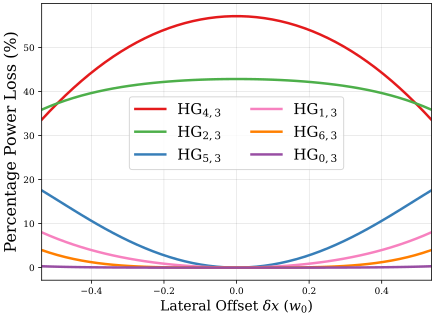

In [22]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,0]/powerMisalignment_x_3, label=r"$\mathrm{HG}_{4,3}$", color=CB_color_cycle[7], lw=2.5)
ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,4]/powerMisalignment_x_3, label=r"$\mathrm{HG}_{2,3}$", color=CB_color_cycle[2], lw=2.5)

ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,1]/powerMisalignment_x_3, label=r"$\mathrm{HG}_{5,3}$", color=CB_color_cycle[0], lw=2.5)
ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,5]/powerMisalignment_x_3, label=r"$\mathrm{HG}_{1,3}$", color=CB_color_cycle[3], lw=2.5)

ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,2]/powerMisalignment_x_3, label=r"$\mathrm{HG}_{6,3}$", color=CB_color_cycle[1], lw=2.5)
ax.plot(xs/w0, 100*powerMisalignment_x_3_HOM[:,6]/powerMisalignment_x_3, label=r"$\mathrm{HG}_{0,3}$", color=CB_color_cycle[5], lw=2.5)

legend = plt.legend(fontsize=15, ncols=2, loc=(0.225, 0.4))

ax.set_xlabel(r"Lateral Offset $\delta x$ ($w_{0}$)", fontsize=14)
ax.set_ylabel("Percentage Power Loss (%)", fontsize=16);
# fig.savefig('/Users/liutao/Desktop/Thesis/Alignment and mode mismatch/HG33_modepercentage_Lateraloffset.pdf', bbox_inches='tight', dpi=300, pad_inches=0.01);


In [11]:
print("The ratio between HG43 and HG23 in the linear region is: ", (powerMisalignment_x_3_HOM[:,0]/ \
powerMisalignment_x_3).max()/(powerMisalignment_x_3_HOM[:,4]/powerMisalignment_x_3).max())
# 4/3

The ratio between HG43 and HG23 in the linear region is:  1.3331731934546809


In [7]:
def eta_nm_MMfunc(q, n, m, HG33_prime_data):
    HGnm = HGMode(q=q, n=n, m=m)
    HGnm_data = HGnm.unm(x, y)

    rho_nm = np.sum(np.conj(HGnm_data)*HG33_prime_data * step * step)
    eta_nm = np.abs(rho_nm*np.conj(rho_nm))
    
    return eta_nm

In [3]:
x = y = np.linspace(-1, 1, 400)*0.005
step = x[1]-x[0]
def eta_HOM(q_0, q_prime):
    HG33_prime = HGMode(q_prime, n=3, m=3)
    HG33_prime_data = HG33_prime.unm(x, y)
    
    modess = [["35", "53"], ["31", "13"], ["73", "37", "55"], ["44", "80", "08"], ["42", "24"]]

    eta_nmMMs = []
    eta_nmMM_sum = []
    for modes in modess:
        eta_nm_order = []
        for mode in modes:
            n = int(mode[0])
            m = int(mode[1])
            eta_nmMM = eta_nm_MMfunc(q=q_0, n=n, m=m, HG33_prime_data=HG33_prime_data)
            eta_nm_order.append(eta_nmMM)
        eta_nmMM_sum.append(sum(eta_nm_order))
        eta_nmMMs.append(eta_nm_order)
            
    return eta_nmMM_sum, eta_nmMMs
    
q_0 = 1j 
zR = np.imag(q_0)
w0 = (np.imag(q_0)*(1064e-9)/np.pi)**0.5
zs = np.linspace(0, 1, 50)*0.4*zR

# HG33_z_s = []
HG35_z_s = []
HG53_z_s = []
HG31_z_s = []
HG13_z_s = []
HG73_z_s = []
HG37_z_s = []
HG55_z_s = []
MM_sum_z_s = []
for idx, z in enumerate(zs):
    q_prime = q_0 + z
    MM_sum_z, [[HG35, HG53], [HG31, HG13], [HG73, HG37, HG55], [HG44, HG80, HG08], [HG42, HG24]] = eta_HOM(q_0, q_prime)
    # HG33_z_s.append(HG33)
    
    HG35_z_s.append(HG35)
    HG53_z_s.append(HG53)
    HG31_z_s.append(HG31)
    HG13_z_s.append(HG13)
    
    HG73_z_s.append(HG73)
    HG37_z_s.append(HG37)
    HG55_z_s.append(HG55)
    MM_sum_z_s.append(MM_sum_z)

    # powerMM_z_3_HOM.append(eta_nmMMs)

# HG33_z_s = np.array(HG33_z_s)
HG13_z_s = np.array(HG13_z_s)
HG31_z_s = np.array(HG31_z_s)
HG53_z_s = np.array(HG53_z_s)
HG35_z_s = np.array(HG35_z_s)
HG37_z_s = np.array(HG37_z_s)
HG73_z_s = np.array(HG73_z_s)
HG55_z_s = np.array(HG55_z_s)

MM_sum_z_s = np.array(MM_sum_z_s)


ws = (1+np.linspace(0, 1, 50)*0.2)*w0
# HG33_w_s = []

HG35_w_s = []
HG53_w_s = []
HG31_w_s = []
HG13_w_s = []
HG73_w_s = []
HG37_w_s = []
HG55_w_s = []
MM_sum_w_s = []
for idx, w in enumerate(ws):
    zR_new = np.pi*w**2/(1064e-9)
    q_prime = q_0.real + 1j*zR_new

    MM_sum_w, [[HG35, HG53], [HG31, HG13], [HG73, HG37, HG55], [HG44, HG80, HG08], [HG42, HG24]] = eta_HOM(q_0, q_prime)
    # HG33_w_s.append(HG33)
    
    HG35_w_s.append(HG35)
    HG53_w_s.append(HG53)
    HG31_w_s.append(HG31)
    HG13_w_s.append(HG13)

    HG73_w_s.append(HG73)
    HG37_w_s.append(HG37)
    HG55_w_s.append(HG55)
    MM_sum_w_s.append(MM_sum_w)
    
MM_sum_w_s = np.array(MM_sum_w_s)
# HG33_w_s = np.array(HG33_w_s)
HG13_w_s = np.array(HG13_w_s)
HG31_w_s = np.array(HG31_w_s)
HG53_w_s = np.array(HG53_w_s)
HG35_w_s = np.array(HG35_w_s)
HG37_w_s = np.array(HG37_w_s)
HG73_w_s = np.array(HG73_w_s)
HG55_w_s = np.array(HG55_w_s)

summw = np.sum(MM_sum_w_s, axis=1)
summz = np.sum(MM_sum_z_s, axis=1)

In [24]:
MM_sum_z_s.shape, summw.shape

((50, 5), (50,))

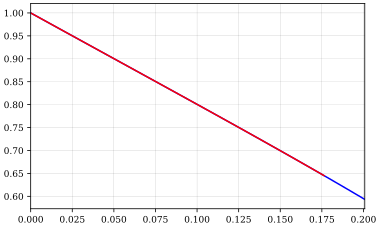

In [58]:
# plt.plot(summz, HG33_z_s, label=r"HG$_{1,3}$, z")
# plt.plot(summz, HG31_z_s, ls="--", label=r"HG$_{3,1}$, z")
# plt.plot(summz, HG53_z_s, label=r"HG$_{5,3}$, z")
# plt.plot(summz, HG35_z_s, ls="--", label=r"HG$_{3,5}$, z")

# plt.plot(summw, HG33_w_s, label=r"HG$_{1,3}$, z")
# plt.plot(summw, HG31_w_s, ls="--", label=r"HG$_{3,1}$, z")
# plt.plot(summw, HG53_w_s, label=r"HG$_{5,3}$, z")
# plt.plot(summw, HG35_w_s, ls="--", label=r"HG$_{3,5}$, z");

In [40]:
# summw

array([4.36111044e-01, 4.12318120e-01, 3.87517596e-01, 3.61973247e-01,
       3.35944145e-01, 3.09681969e-01, 2.83428671e-01, 2.57414496e-01,
       2.31856359e-01, 2.06956543e-01, 1.82901720e-01, 1.59862247e-01,
       1.37991732e-01, 1.17426830e-01, 9.82872392e-02, 8.06758783e-02,
       6.46792145e-02, 5.03677130e-02, 3.77963902e-02, 2.70054476e-02,
       1.80209670e-02, 1.08556526e-02, 5.50960318e-03, 1.97110551e-03,
       2.17436753e-04, 2.15669194e-04, 1.92347047e-03, 5.28989455e-03,
       1.02561597e-02, 1.67564106e-02, 2.47184634e-02, 3.40645308e-02,
       4.47119287e-02, 5.65737613e-02, 6.95595863e-02, 8.35760587e-02,
       9.85275538e-02, 1.14316768e-01, 1.30845297e-01, 1.48014196e-01,
       1.65724507e-01, 1.83877778e-01, 2.02376536e-01, 2.21124760e-01,
       2.40028303e-01, 2.58995308e-01, 2.77936579e-01, 2.96765934e-01,
       3.15400525e-01, 3.33761125e-01])

(1.2192287856938573-5.003349633597263j)
-11350.665479512903
(2.194219557770321e-28+7.293815792030912e-29j)
(4.878775679551557+0j)
-8182.998949565172
(5.466355352004247e-23+0j)


(-0.5, 399.5, -0.5, 399.5)

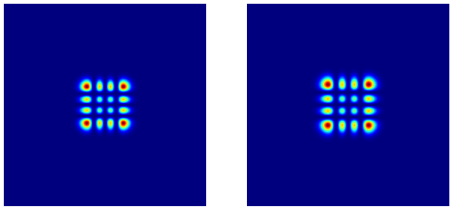

In [95]:
z = zs[0]
q_z_prime = q_0 + z
HG33_z = HGMode(q_z_prime, n=3, m=3)
HG33_z_data = HG33_z.unm(x, y)

w = ws[-1]
zR_new = np.pi*w**2/(1064e-9)
q_w_prime = q_0.real + 1j*zR_new
HG33_w = HGMode(q_w_prime, n=3, m=3)
HG33_w_data = HG33_w.unm(x, y)

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 4))
ax1.imshow(np.abs(HG33_z_data)**2, cmap="jet")
ax2.imshow(np.abs(HG33_w_data)**2, cmap="jet")
ax1.axis("off")
ax2.axis("off")

In [22]:
MM_sum_z_s[:,0].shape, summz.shape

((50,), (50,))

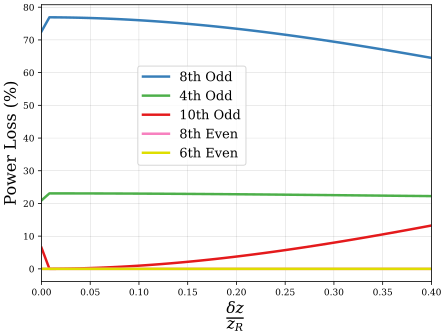

In [25]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(zs/zR, 100*MM_sum_z_s[:,0]/summz, label="8th Odd", color=CB_color_cycle[0], lw=2.5)

ax.plot(zs/zR, 100*MM_sum_z_s[:,1]/summz, label="4th Odd", color=CB_color_cycle[2], lw=2.5)
ax.plot(zs/zR, 100*MM_sum_z_s[:,2]/summz, label="10th Odd", color=CB_color_cycle[7], lw=2.5)

ax.plot(zs/zR, 100*MM_sum_z_s[:,3]/summz, label="8th Even", color=CB_color_cycle[3], lw=2.5)
ax.plot(zs/zR, 100*MM_sum_z_s[:,4]/summz, label="6th Even", color=CB_color_cycle[8], lw=2.5)

legend = plt.legend(fontsize=13, ncols=1, loc=(0.247, 0.42))

ax.set_xlabel(r"$\frac{\delta z}{z_{R}}$", fontsize=22)
ax.set_ylabel("Power Loss (%)", fontsize=16);

In [97]:
(powerMM_z_3_HOM[:,0]/summz)[25], (powerMM_z_3_HOM[:,1]/summz)[25], (powerMM_z_3_HOM[:,0]/summz)[25] / (powerMM_z_3_HOM[:,1]/summz)[25]

(0.7691699017049507, 0.2307644257428274, 3.333138975944857)

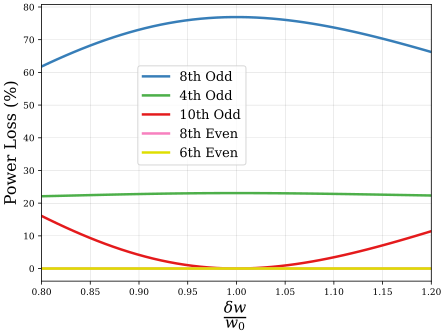

In [98]:
fig, ax = plt.subplots(figsize=(7, 5))

summw = np.sum(powerMM_w_3_HOM, axis=1)

ax.plot(ws/w0, 100*powerMM_w_3_HOM[:,0]/summw, label="8th Odd", color=CB_color_cycle[0], lw=2.5)

ax.plot(ws/w0, 100*powerMM_w_3_HOM[:,1]/summw, label="4th Odd", color=CB_color_cycle[2], lw=2.5)
ax.plot(ws/w0, 100*powerMM_w_3_HOM[:,2]/summw, label="10th Odd", color=CB_color_cycle[7], lw=2.5)

ax.plot(ws/w0, 100*powerMM_w_3_HOM[:,3]/summw, label="8th Even", color=CB_color_cycle[3], lw=2.5)
ax.plot(ws/w0, 100*powerMM_w_3_HOM[:,4]/summw, label="6th Even", color=CB_color_cycle[8], lw=2.5)


legend = plt.legend(fontsize=13, ncols=1, loc=(0.247, 0.42))

ax.set_xlabel(r"$\frac{\delta w}{w_{0}}$", fontsize=22)
ax.set_ylabel("Power Loss (%)", fontsize=16);

In [99]:
(powerMM_w_3_HOM[:,0]/summw)[25], (powerMM_w_3_HOM[:,1]/summw)[25], (powerMM_w_3_HOM[:,0]/summw)[25] / (powerMM_w_3_HOM[:,1]/summw)[25]

(0.7691701488641338, 0.23076444525286577, 3.333139765189117)

In [22]:
base = finesse.Model()
base.modes(maxtem=14)
base.parse(
    """
    l L0 P=1
    tem(L0, n=0, m=0, factor=0)
    tem(L0, m=3, n=3, factor=1)
    
    s s0 L0.p1 m1.p1
    m m1 R=0.99 T=0.01 Rc=-0.7
    s CAV m1.p2 m2.p1 L=1
    m m2 R=0.991 T=0.009 Rc=0.7

    cavity cavity1 source=m1.p2.o via=m2.p1.i priority=1

    xaxis(m1.phi, lin, -180, 180, 1001)
    """
)

kat0 = base.deepcopy()
kat0.parse("ad HGmode m2.p2.o f=0 n=3 m=3")
out0 = kat0.run()
Ptrans = np.abs(out0["HGmode"]).max()**2
Ptrans

0.969657095477252

In [31]:
kat = base.deepcopy()

for ModeOrder in [0, 2, 4, 6, 8, 10, 12, 14]:
    for n in range(0, ModeOrder+1, 1):
        m = ModeOrder-n
        kat.parse(f"ad HG{n}_{m} m2.p2.o f=0 n={n} m={m}")
        
katt = kat.deepcopy()
mm_gauss = katt.create_mismatch(katt.m1.p1.i, w0_mm=20.25)
out = katt.run()

In [24]:
sol_array = []
for output in out.outputs:
    sol_array.append(out[output])
sol_array = np.array(sol_array)
sol_array.shape

(48, 1002)

In [25]:
powers_2 = []
powers_4 = []
powers_6 = []
powers_8 = []
powers_10 = []
powers_12 = []
powers_14 = []
for i in range(sol_array.shape[0]):
    detector = np.abs(sol_array[i,:])**2
    mode_power = detector.max()
    if mode_power>1e-6:
        n, m = out.outputs[i][2:].split("_")
        n = int(n)
        m = int(m)
        mode_order = n+m
        
        eval(f"powers_{mode_order}").append((out.outputs[i], mode_power))

powers = []
for power in [powers_2, powers_4, powers_6, powers_8, powers_10, powers_12, powers_14]:
    if power:
        power_mo = np.array(power)[:,1].astype("float").sum()
        powers.append(power_mo)
powers = np.array(powers)
powers.sum()/Ptrans

1.0003677841775034

In [26]:
powers_6

[('HG1_5', 0.006443028571047632),
 ('HG3_3', 0.6191741812466167),
 ('HG5_1', 0.006443028571047632)]

In [27]:
1 - powers_6[1][1]/Ptrans

0.36145036824397425

In [32]:
def powerModeOrder(w=0, z=0):
    katt = kat.deepcopy()
    mm_gauss = katt.create_mismatch(katt.m1.p1.i, w0_mm=w, z_mm=z)
    out = katt.run()

    sol_array = []
    for output in out.outputs:
        sol_array.append(out[output])
    sol_array = np.array(sol_array)
    powers_0 = []
    powers_2 = []
    powers_4 = []
    powers_6 = []
    powers_6_scatter = []
    powers_8 = []
    powers_10 = []
    powers_12 = []
    powers_14 = []
    for i in range(sol_array.shape[0]):
        detector = np.abs(sol_array[i,:])**2
        mode_power = detector.max()
        if mode_power>1e-6:
            n, m = out.outputs[i][2:].split("_")
            n = int(n)
            m = int(m)
            mode_order = n+m

            if mode_order == 6:
                if n == 3:
                    powers_6.append(mode_power)
                else:
                    powers_6_scatter.append(mode_power)
            else:
                eval(f"powers_{mode_order}").append(mode_power)
    powerss = [sum(powers_6), sum(powers_6_scatter), sum(powers_2), sum(powers_4), sum(powers_8), 
               sum(powers_10), sum(powers_12), sum(powers_0), sum(powers_14)]
    powerss = np.array(powerss)
    return powerss

In [65]:
powerss_w = []
# ws = np.linspace(0, 24, 30)
ws = np.linspace(0, 40, 30)
for w in ws:
    powerss = powerModeOrder(w=w)
    powerss_w.append(powerss)
    print("#", end=" ")
powerss_w = np.array(powerss_w)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

In [25]:
powerss_z = []
zs = np.linspace(0, 28, 30)
for z in zs:
    powerss = powerModeOrder(z=z)
    powerss_z.append(powerss)
    print("#", end=" ")
powerss_z = np.array(powerss_z)

# # # # # # # # # # # # # # # # # # # # # # # # # # # # # # 

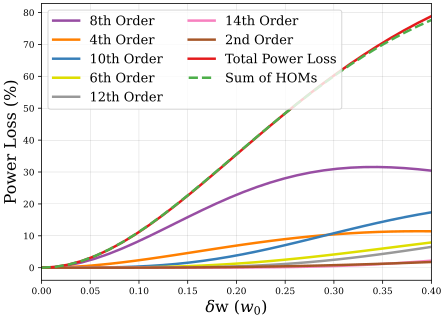

In [75]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(ws/100, 100*powerss_w[:,4]/Ptrans, label="8th Order", color=CB_color_cycle[5], lw=2.5)
ax.plot(ws/100, 100*powerss_w[:,3]/Ptrans, label="4th Order", color=CB_color_cycle[1], lw=2.5)
ax.plot(ws/100, 100*powerss_w[:,5]/Ptrans, label="10th Order", color=CB_color_cycle[0], lw=2.5)
ax.plot(ws/100, 100*powerss_w[:,1]/Ptrans, label="6th Order", color=CB_color_cycle[8], lw=2.5)
ax.plot(ws/100, 100*powerss_w[:,6]/Ptrans, label="12th Order", color=CB_color_cycle[6], lw=2.5)
# ax.plot(ws, 100*powerss_w[:,7]/Ptrans, label="0th Order Modes", color=CB_color_cycle[3], lw=2.5)

ax.plot(ws/100, 100*powerss_w[:,8]/Ptrans, label="14th Order", color=CB_color_cycle[3], lw=2.5)
ax.plot(ws/100, 100*powerss_w[:,2]/Ptrans, label="2nd Order", color=CB_color_cycle[4], lw=2.5)

ax.plot(ws/100, 100*(Ptrans-powerss_w[:,0])/Ptrans, label="Total Power Loss", color=CB_color_cycle[7], lw=2.5)

ax.plot(ws/100, 100*np.sum(powerss_w[:,1:]/Ptrans, axis=1),  "--", label="Sum of HOMs", color=CB_color_cycle[2], lw=2.5)

# ax.hlines(y=33.6, xmin=0., xmax=20.1, ls="--", lw=2.5, label=r"$\mathrm{HG}_{3,3}$ Power Loss")

# arr = np.abs(100*np.sum(powerss_w[:,1:]/Ptrans, axis=1) - 33.6)
# index_w = np.argmin(arr)
# print(index_w)

# ax.plot(ws[index_w], 100*np.sum(powerss_w[index_w,1:]/Ptrans), "*", color="r", markersize=15)
legend = plt.legend(fontsize=13, ncols=2, loc="upper left")

ax.set_xlabel(r"$\delta$w ($w_{0}$)", fontsize=16)
ax.set_ylabel("Power Loss (%)", fontsize=16);

# fig.savefig('/Users/liutao/Desktop/Thesis/Alignment and mode mismatch/HG33_content_waistsizemismatch.pdf', 
#             bbox_inches='tight', dpi=300, pad_inches=0.01);

In [516]:
print(100*powerss_w[index_w,3]/36.16, 100*powerss_w[index_w,4]/36.16, 100*powerss_w[index_w,5]/36.16)

0.1842136133687842 0.6080296255762844 0.10074465674863196


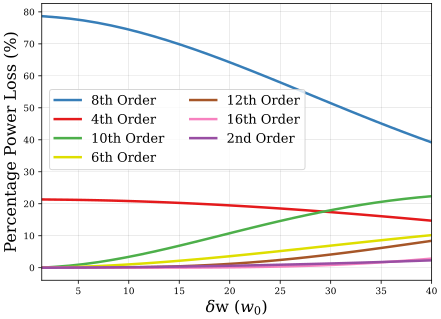

In [87]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(ws[1:], 100*powerss_w[1:,4]/np.sum(powerss_w[1:,1:], axis=1), label="8th Order", color=CB_color_cycle[0], lw=2.5)
ax.plot(ws[1:], 100*powerss_w[1:,3]/np.sum(powerss_w[1:,1:], axis=1), label="4th Order", color=CB_color_cycle[7], lw=2.5)
ax.plot(ws[1:], 100*powerss_w[1:,5]/np.sum(powerss_w[1:,1:], axis=1), label="10th Order", color=CB_color_cycle[2], lw=2.5)

ax.plot(ws[1:], 100*powerss_w[1:,1]/np.sum(powerss_w[1:,1:], axis=1), label="6th Order", color=CB_color_cycle[8], lw=2.5)
ax.plot(ws[1:], 100*powerss_w[1:,6]/np.sum(powerss_w[1:,1:], axis=1), label="12th Order", color=CB_color_cycle[4], lw=2.5)
ax.plot(ws[1:], 100*powerss_w[1:,8]/np.sum(powerss_w[1:,1:], axis=1), label="16th Order", color=CB_color_cycle[3], lw=2.5)
ax.plot(ws[1:], 100*powerss_w[1:,2]/np.sum(powerss_w[1:,1:], axis=1), label="2nd Order", color=CB_color_cycle[5], lw=2.5)

# arr = np.abs(100*np.sum(powerss_w[:,1:]/Ptrans, axis=1) - 33.6)
# index_w = np.argmin(arr)
# print(index_w)

legend = plt.legend(fontsize=13, ncols=2, loc=(0.02, 0.4))

ax.set_xlabel(r"$\delta$w ($w_{0}$)", fontsize=16)
ax.set_ylabel("Percentage Power Loss (%)", fontsize=16);

# fig.savefig('/Users/liutao/Desktop/Thesis/Alignment and mode mismatch/HG33_percentage_waistsizemismatch.pdf', 
#             bbox_inches='tight', dpi=300, pad_inches=0.01);

In [94]:
100*powerss_w[1:,3]/np.sum(powerss_w[1:,1:], axis=1)

array([21.34431684, 21.29393435, 21.24631764, 21.18003632, 21.09466267,
       20.9933644 , 20.87544547, 20.7405389 , 20.58942082, 20.42282652,
       20.24069706, 20.04329801, 19.83089473, 19.60359848, 19.36192883,
       19.10609659, 18.83644137, 18.55334081, 18.25710184, 17.94835956,
       17.62755126, 17.29523474, 16.95201471, 16.59854042, 16.23550195,
       15.86362547, 15.48366754, 15.09640879, 14.70264717])

In [105]:
22/6

3.6666666666666665

In [99]:
78.65568316/21.34431684

3.685087873723673

23


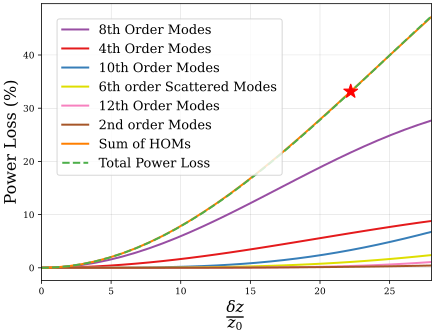

In [36]:
fig, ax = plt.subplots(figsize=(7, 5))

ax.plot(zs, 100*powerss_z[:,4]/Ptrans, label="8th Order Modes", color=CB_color_cycle[5], lw=2.5)
ax.plot(zs, 100*powerss_z[:,3]/Ptrans, label="4th Order Modes", color=CB_color_cycle[7], lw=2.5)
ax.plot(zs, 100*powerss_z[:,5]/Ptrans, label="10th Order Modes", color=CB_color_cycle[0], lw=2.5)
ax.plot(zs, 100*powerss_z[:,1]/Ptrans, label="6th order Scattered Modes", color=CB_color_cycle[8], lw=2.5)
ax.plot(zs, 100*powerss_z[:,6]/Ptrans, label="12th Order Modes", color=CB_color_cycle[3], lw=2.5)
ax.plot(zs, 100*powerss_z[:,2]/Ptrans, label="2nd order Modes", color=CB_color_cycle[4], lw=2.5)

ax.plot(zs, 100*np.sum(powerss_z[:,1:]/Ptrans, axis=1), label="Sum of HOMs", color=CB_color_cycle[1], lw=2.5)
ax.plot(zs, 100*(Ptrans-powerss_z[:,0])/Ptrans, "--", label="Total Power Loss", color=CB_color_cycle[2], lw=2.5)

# ax.hlines(y=33.6, xmin=0., xmax=23.5, ls="--", lw=2.5, label=r"$\mathrm{HG}_{3,3}$ Power Loss")

arr = np.abs(100*np.sum(powerss_z[:,1:]/Ptrans, axis=1) - 33.6)
index_z = np.argmin(arr)
print(index_z)

ax.plot(zs[index_z], 100*np.sum(powerss_z[index_z,1:]/Ptrans), "*", color="r", markersize=15)
legend = plt.legend(fontsize=13, ncols=1, loc=(0.04, 0.38))

ax.set_xlabel(r"$\frac{\delta z}{z_{0}}$", fontsize=22)
ax.set_ylabel("Power Loss (%)", fontsize=16);

In [581]:
for mode in np.arange(1, 7):
    print(10000*powerss_z[index_z, mode]/33.6)

3.173092769972617
0.5309230659065081
18.807787825150285
62.54604515844011
9.62765318877416
0.9785051374858761


In [546]:
for mode in np.arange(1, 7):
    print(10000*powerss_w[index_w, mode]/33.6)

3.1457621537840397
0.5260711733433354
18.74033569802367
62.35206961280635
9.550432381100208
0.9659032233173158
